In [1]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib
importlib.reload(icrms)



<module 'corems.lc_icpms_ftms.calc.lc_icrms_qc_assign' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_qc_assign.py'>

In [4]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)


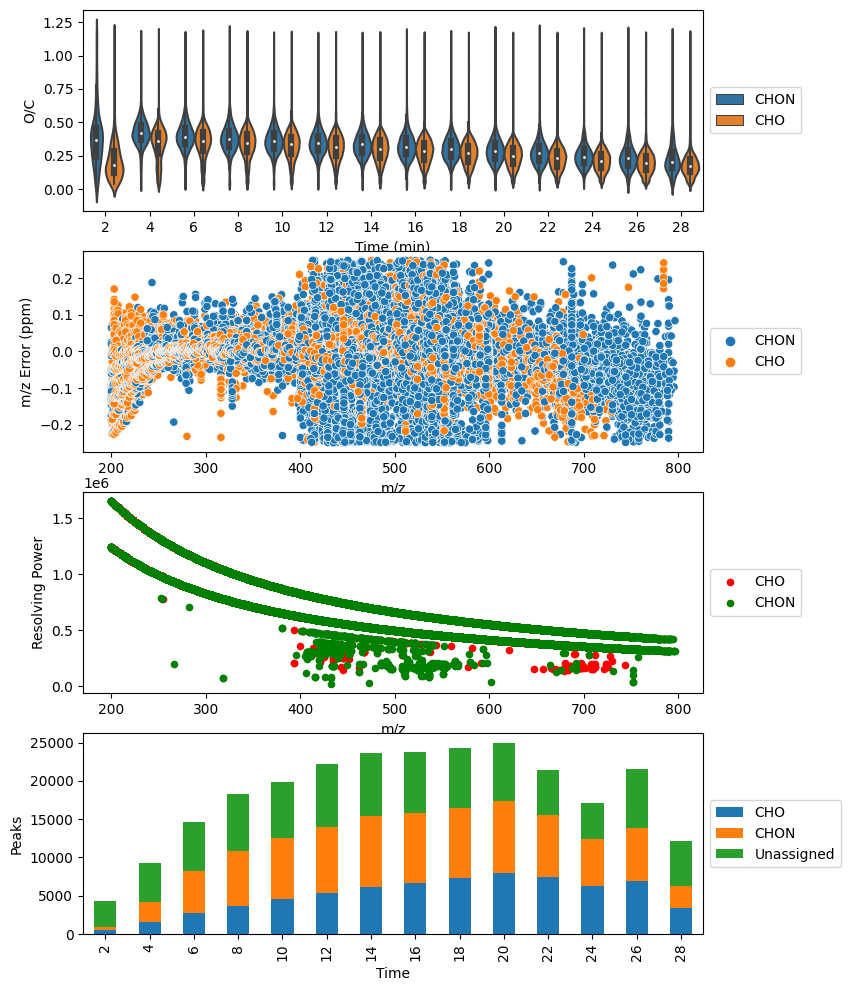

In [6]:
data.assess_all_results() ## why is it necessary to run this to get self.complete_results_df?

In [23]:
# load data from .csv; add following columns: 'm/z window', 'Rep', 'm/z Window Size'

data_df = pd.read_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-all_22-12-13.csv")

data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())


data_df['m/z Window Size'] = data_df.Index

for i in range(len(data_df['m/z window'])):

    w = data_df['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        data_df['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        data_df['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        data_df['m/z Window Size'].iloc[i] = '1000 m/z'

print(data_df['m/z Window Size'].unique())



20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
[2 1]
['200-1200 m/z' '400-500 m/z' '400-600 m/z' '500-600 m/z']


array(['1000 m/z', '100 m/z', '200 m/z'], dtype=object)

In [24]:
#create subsets of assignments based m/z window

list100mz = []
list200mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-600 m/z') or (mzwindow == '600-800 m/z'):
        list200mz.append(r_df)

    elif (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mz200 = pd.concat(list200mz)
mzfull = pd.concat(listfullzmz)


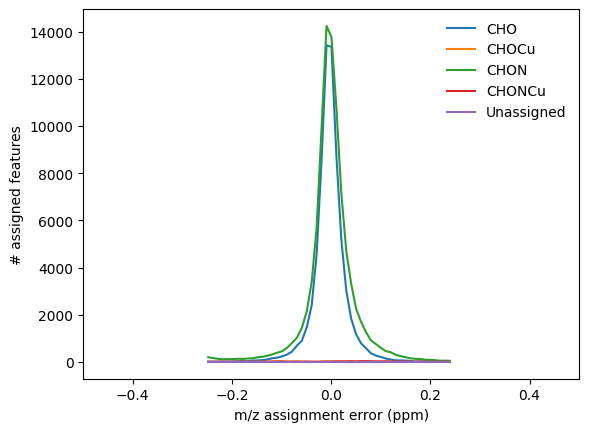

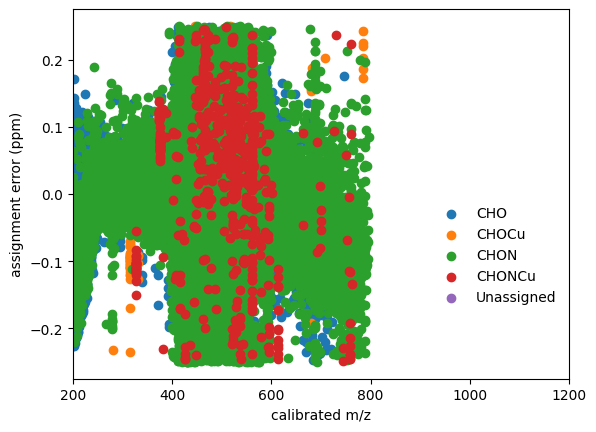

In [25]:
# plot assignment error distribution for full data set
lcmsfns.pltMZerror(lcmsfns.assignMolClass(data_df))

plt.show()

lcmsfns.pltMZerror_pts(lcmsfns.assignMolClass(data_df))

plt.show()

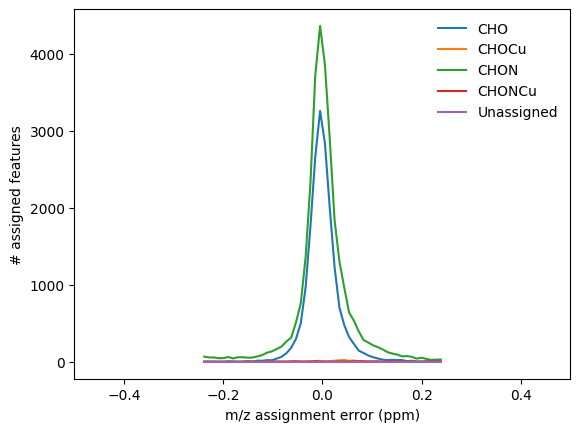

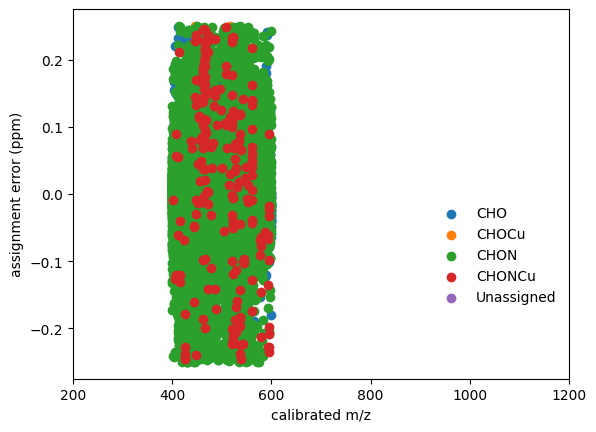

In [26]:
# plot assignment error dist for m/z 100 scans
lcmsfns.pltMZerror(lcmsfns.assignMolClass(mz100))

plt.show()

lcmsfns.pltMZerror_pts(lcmsfns.assignMolClass(mz100))

plt.show()

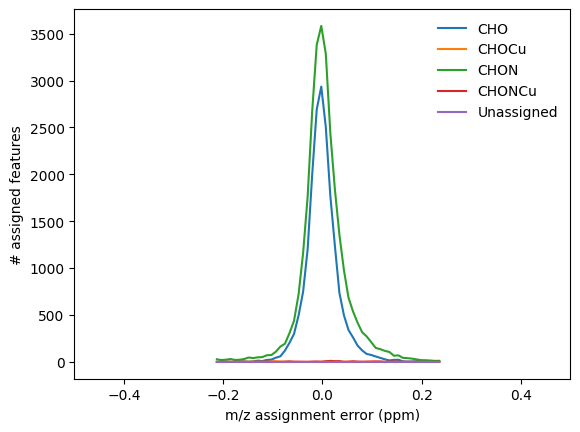

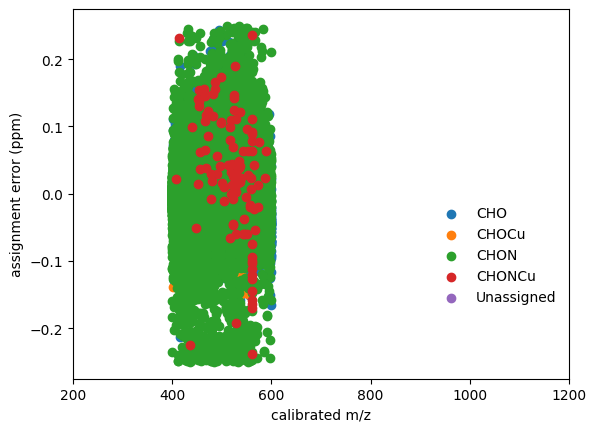

In [27]:
# plot assignment error dist for m/z 200 scans
lcmsfns.pltMZerror(lcmsfns.assignMolClass(mz200))

plt.show()

lcmsfns.pltMZerror_pts(lcmsfns.assignMolClass(mz200))

plt.show()

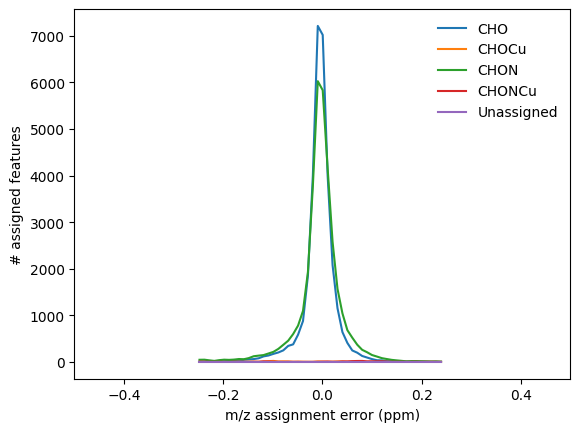

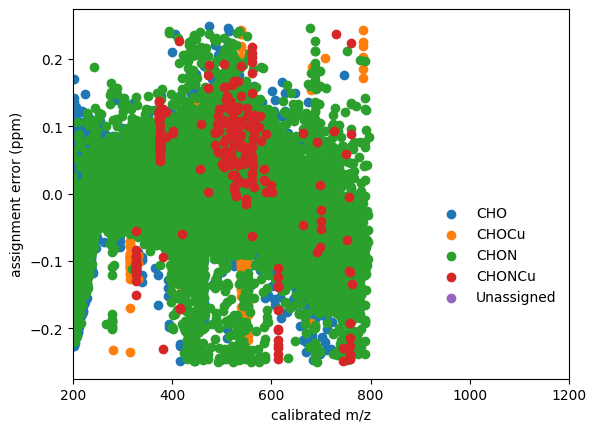

In [28]:
# plot assignment error dist for full m/z scans 
lcmsfns.pltMZerror(lcmsfns.assignMolClass(mzfull))

plt.show()

lcmsfns.pltMZerror_pts(lcmsfns.assignMolClass(mzfull))

plt.show()

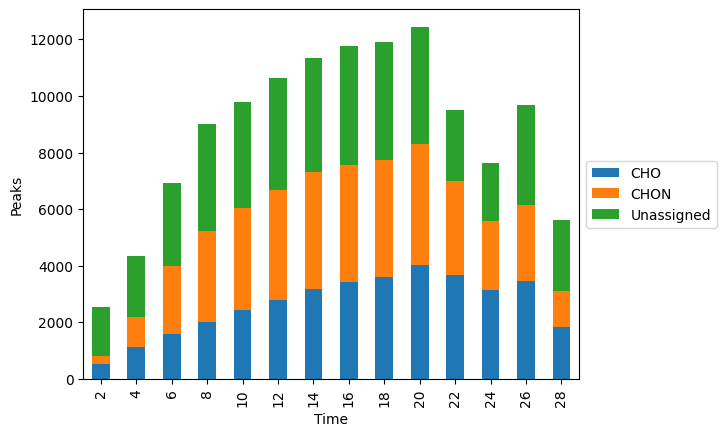

In [148]:
all_results = mzfull


all_results['N']=all_results['N'].fillna(0)
all_results['O']=all_results['O'].fillna(0)
#self.all_results['S']=self.all_results['S'].fillna(0)
#self.all_results['P']=self.all_results['P'].fillna(0)
#self.all_results['Na']=self.all_results['Na'].fillna(0)

all_results['mol_class']='Unassigned'
all_results['mol_class'][all_results['C']>0]='CHO'
all_results['mol_class'][(all_results['C']>0) & (all_results['N']>0.5)]='CHON'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['S']>0.5)]='CHOS'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['P']>0.5)]='CHOP'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['Na']>0.5)]='CHONa'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['S']>0.5) & (self.all_results['N']>0.5)]='CHONS'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['P']>0.5) & (self.all_results['N']>0.5)]='CHONP'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['Na']>0.5) & (self.all_results['N']>0.5)]='CHONNa'
#self.all_results['mol_class'][(self.all_results['C']>0) & (self.all_results['P']>0.5) & (self.all_results['Na']>0.5) & (self.all_results['N']>0.5)]='CHONPNa'


results= all_results[all_results['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']


colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHONP':'black', 'CHONNa':'cyan','CHONPNa':'pink','CHONa':'aqua','CHOP':'gray'}

results= data_df[data_df['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']


colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHONP':'black', 'CHONNa':'cyan','CHONPNa':'pink','CHONa':'aqua','CHOP':'gray'}

grouped=results.groupby('mol_class')
fig, ax4 = plt.subplots()


assign_summary=[]
for time in all_results['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(all_results['mol_class'].unique()):
        current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()
    

In [142]:
# collect assigned results and then unique assigned results; group results by m/z window (100, 200, full) over 400-600 m/z 

assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-600 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('400-600 m/z, 200 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz200)[0], np.shape(assigned_200mz)[0], np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100))
print('200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)
unique_200mz = lcmsfns.getUniqueFeatures(assigned_200mz)
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)

assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=600)]

assigned_200mz_456 = assigned_200mz[(assigned_200mz['m/z']>=400)]
assigned_200mz_456 = assigned_200mz_456[(assigned_200mz_456['m/z']<=600)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=600)]

mz200_456 = mz200[(mz200['m/z']>=400)]
mz200_456 = mz200_456[(mz200_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

print('400-600 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-600 m/z, 200 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz200_456)[0], np.shape(assigned_200mz_456)[0], np.shape(assigned_200mz_456)[0] / np.shape(mz200_456)[0] * 100))
print('\n400-600 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))

unique_100mz_456 = lcmsfns.getUniqueFeatures(assigned_100mz_456)
unique_200mz_456 = lcmsfns.getUniqueFeatures(assigned_200mz_456)
unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

400-600 m/z, 100 m/z windowing: 
98016 features total; 54941 assigned (56.1%)
400-600 m/z, 200 m/z windowing: 
83209 features total; 52827 assigned (63.5%)
200-800 m/z window (full scan): 
123098 features total; 77677 assigned (63.1%)
total # results: 54941
# unique results: 32642
total # results: 52827
# unique results: 28154
total # results: 77677
# unique results: 39449
400-600 m/z, 100 m/z windowing: 
98016 features total
54941 assigned (56.1%)

400-600 m/z, 200 m/z windowing: 
83209 features total
52827 assigned (63.5%)

400-600 m/z, full window: 
56612 features total
34241 assigned (60.5%)
total # results: 54941
# unique results: 32642
total # results: 52827
# unique results: 28154
total # results: 34241
# unique results: 17911


"\nax2.set_xlim(xmin,xmax)\nsns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=combo,ax=ax3,s=ps)\nsns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=combo,ax=ax4)\n\nax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))\nax1.set_title('Overall Assignment Error')\nax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))\nax2.set_title('Overall assignment error')\nax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))\nax3.set_title('Assignment error, N features')\nax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))\nax4.set_title('Resolving power v. m/z')\n"

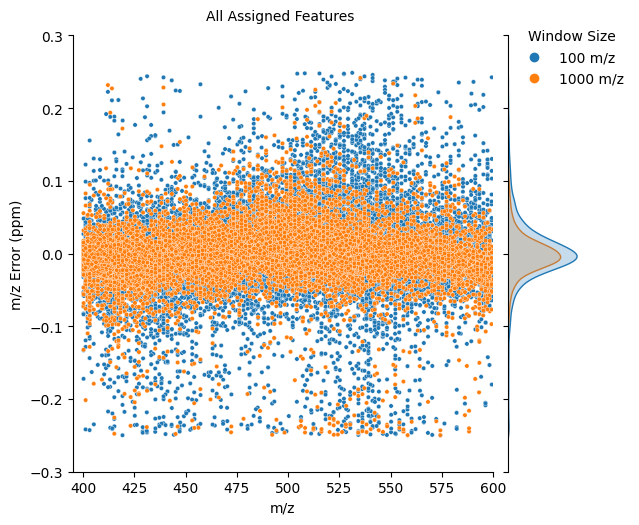

In [141]:
# Figure 1. 

mask = ~unique_100mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_nb=unique_100mz_456[mask]
df_100 = lcmsfns.assignMolClass(unique_100mz_nb)

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]
df_full = lcmsfns.assignMolClass(unique_fullmz_nb)

combo = pd.concat([df_100, df_full],ignore_index=True)

ps=10
xlim = [395,600]
xmin = xlim[0]
xmax = xlim[1]
g = sns.jointplot(data=combo, x='m/z',y='m/z Error (ppm)', hue='m/z Window Size', s=ps, xlim=[395,600], ylim = [-.3,.3])
g.ax_marg_x.remove()
h, l = g.fig.get_axes()[0].get_legend_handles_labels()#  
g.fig.get_axes()[0].legend_.remove() #legend(bbox_to_anchor=(1.2,0.5), loc='center left',frameon = False, title = 'Window Size')
g.fig.get_axes()[1].legend(h, l, bbox_to_anchor=(0.0,0.95), loc='center left',frameon = False, title = 'Window Size')
g.fig.text(0.475,0.85,'All Assigned Features', horizontalalignment='center')
#plt.legend(loc='center left',)
#fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize = (12,12))
##fig, ax1  = plt.subplots()
#sns.scatterplot(x='m/z',y='m/z Error (ppm)',data=df_100[df_100['Cu']>0],hue='m/z window', s=ps*4, ax=ax2)
#sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z Window Size', data=combo, ax=ax1,s=ps)


#plt.tight_layout()
#plt.show()
#fig.savefig('unique_results.pdf', bbox_to_inches='tight')

'''
ax2.set_xlim(xmin,xmax)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=combo,ax=ax3,s=ps)
sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=combo,ax=ax4)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Overall Assignment Error')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Overall assignment error')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax3.set_title('Assignment error, N features')
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax4.set_title('Resolving power v. m/z')
'''

Text(0.475, 0.85, 'Cu Containing Features')

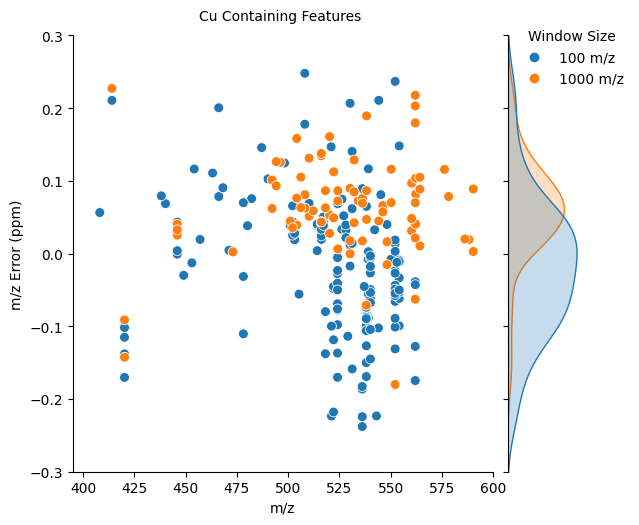

In [ ]:
ps=50
xlim = [395,600]
xmin = xlim[0]
xmax = xlim[1]
df_full_Cu = df_full[(df_full['Cu']>0) ]

g = sns.jointplot(data=combo[combo['Cu']>0], x='m/z',y='m/z Error (ppm)', hue='m/z Window Size', s=ps, xlim=[395,600], ylim = [-.3,.3])
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
g.ax_marg_x.remove()
h, l = g.fig.get_axes()[0].get_legend_handles_labels()#  
g.fig.get_axes()[0].legend_.remove() #legend(bbox_to_anchor=(1.2,0.5), loc='center left',frameon = False, title = 'Window Size')
g.fig.get_axes()[1].legend(h, l, bbox_to_anchor=(0.0,0.95), loc='center left',frameon = False, title = 'Window Size')

g.fig.text(0.475,0.85,'Cu Containing Features', horizontalalignment='center')

Text(0.475, 0.85, '100 m/z Window')

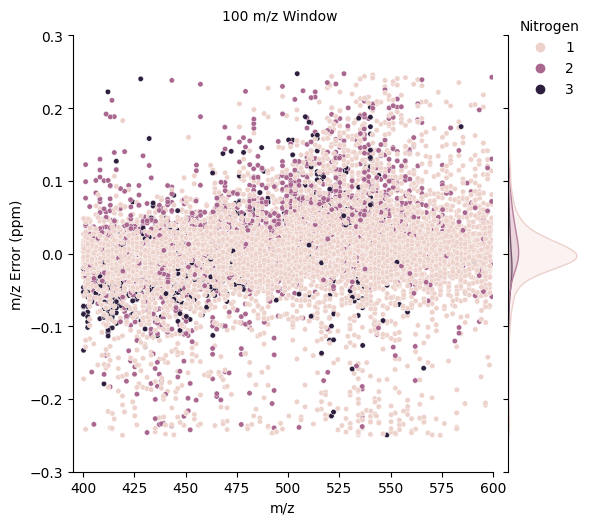

In [140]:
ps=15
xlim = [395,600]
xmin = xlim[0]
xmax = xlim[1]
df_100_N = df_100[(df_100['N']>0) & (df_100['N']<4) ]

g = sns.jointplot(data=df_100_N, x='m/z',y='m/z Error (ppm)', hue='N', s=ps, xlim=[395,600], ylim = [-.3,.3])
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
g.ax_marg_x.remove()
h, l = g.fig.get_axes()[0].get_legend_handles_labels()#  
g.fig.get_axes()[0].legend_.remove() #legend(bbox_to_anchor=(1.2,0.5), loc='center left',frameon = False, title = 'Window Size')
g.fig.get_axes()[1].legend(h, [1,2,3,4], bbox_to_anchor=(0.0,0.95), loc='center left',frameon = False, title = 'Nitrogen')

g.fig.text(0.475,0.85,'100 m/z Window', horizontalalignment='center')

Text(0.475, 0.85, '1000 m/z Window')

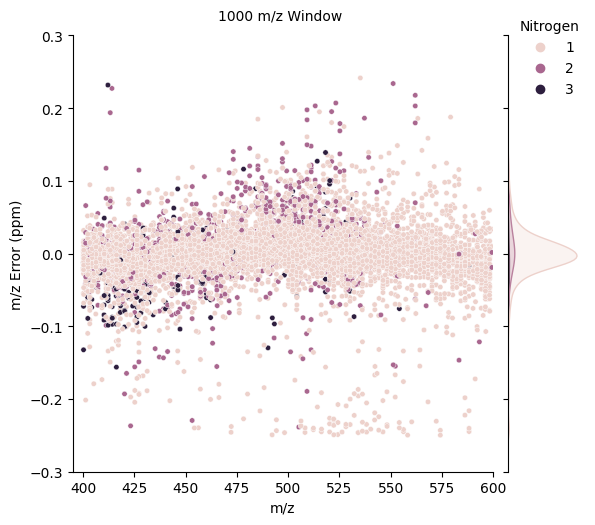

In [139]:
ps=15
xlim = [395,600]
xmin = xlim[0]
xmax = xlim[1]
df_full_N = df_full[(df_full['N']>0) & (df_full['N']<4) ]

g = sns.jointplot(data=df_full_N, x='m/z',y='m/z Error (ppm)', hue='N', s=ps, xlim=[395,600], ylim = [-.3,.3])
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
g.ax_marg_x.remove()
h, l = g.fig.get_axes()[0].get_legend_handles_labels()#  
g.fig.get_axes()[0].legend_.remove() #legend(bbox_to_anchor=(1.2,0.5), loc='center left',frameon = False, title = 'Window Size')
g.fig.get_axes()[1].legend(h, [1,2,3,4], bbox_to_anchor=(0.0,0.95), loc='center left',frameon = False, title = 'Nitrogen')

g.fig.text(0.475,0.85,'1000 m/z Window', horizontalalignment='center')

In [143]:
# blank processing
raw_filelist = data_df['file'].unique()
        
blank_files = [f for f in raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

#rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep1_temp = rep1_temp[rep1_temp['m/z'] >= 600]
#rep1_temp['file'] = 'mz200_600_800_blnk'
#rep1_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])


rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

#rep2_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep2_temp = rep2_temp[rep2_temp['m/z'] >= 600]
#rep2_temp['file'] = 'mz200_600_800_blnk_rep2'
#rep2_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])
# add 200 m/z blank data to master df
mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
data_df = pd.concat([data_df, mz200_blanks])


# add fullmz blanks to blanks df
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw' ]])
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw' ]])

print(blanks_df['m/z window'].unique())


# add blank file column
data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window

    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]


        temp2['blank file'] = btemp2['file'].iloc[0]  # add blank file name 

        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2 # add column w/ blankfile name to appropriate subsets


['500-600 m/z' '400-500 m/z' '400-600 m/z' '200-1200 m/z']


In [24]:
df_unique = lcmsfns.getUniqueFeatures(data_df)
df_bs = lcmsfns.blankSubtract(df_unique, blnkthresh=0.3)


(42151, 54)


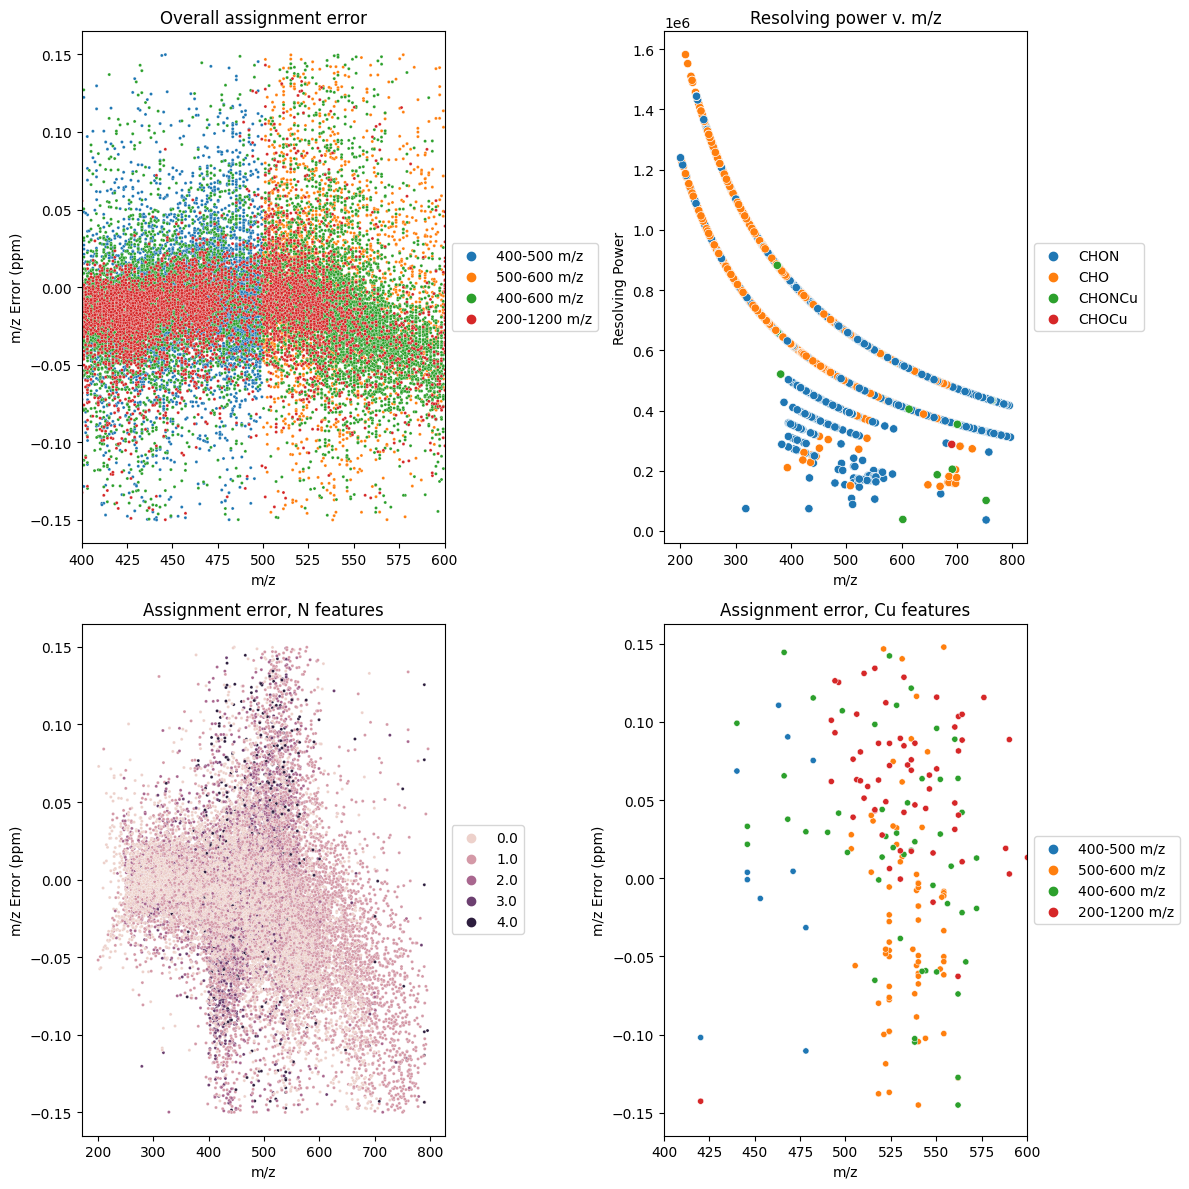

In [25]:
temp = df_bs[abs(df_bs['m/z Error (ppm)'])<0.15]
print(np.shape(temp))
fig = lcmsfns.plotUnique(lcmsfns.assignMolClass(pd.concat([temp[temp['m/z window']== '400-500 m/z'], temp[temp['m/z window']=='500-600 m/z'], temp[temp['m/z window']=='400-600 m/z'], temp[temp['m/z window']=='200-1200 m/z']])),ps=5)

plt.tight_layout()
plt.show()
plt.close('all')

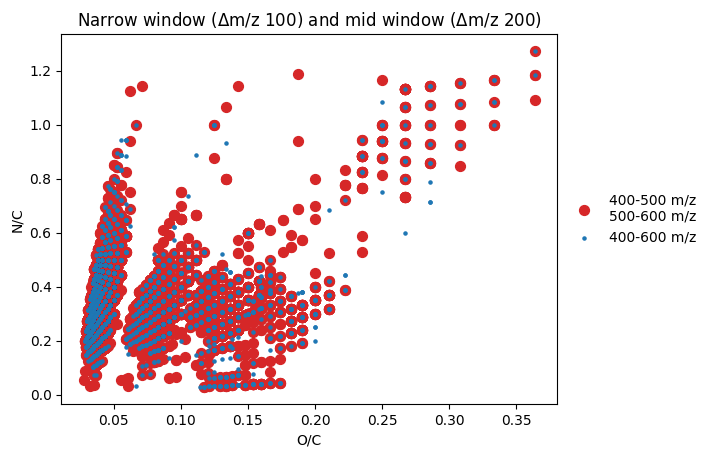

In [345]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='C0',s=5,label='400-600 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


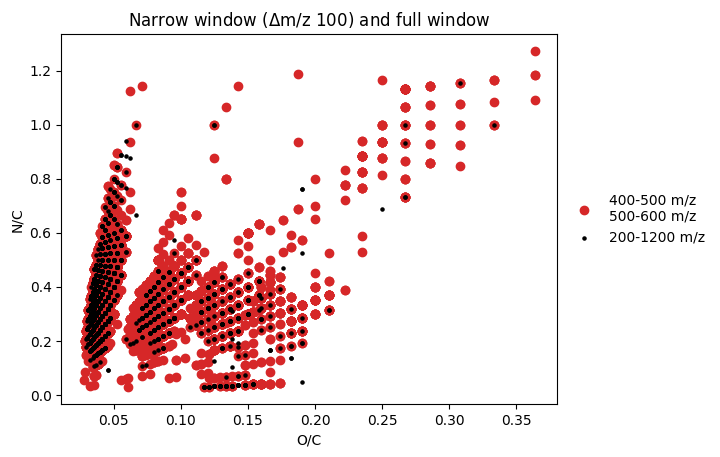

In [346]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='400-600 m/z') #s=df2['S/N'],
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='black',s=5,label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()


In [347]:
temp = df_bs[df_bs['m/z'] >= 400]
temp = temp[temp['m/z']<=600]

temp['m/z Window Size'] = temp.Index

for i in range(len(temp['m/z window'])):

    w = temp['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '1000 m/z'

In [348]:
mz100_contains_cu = mz100_bs[(mz100_bs['Cu'] == 1) ]
print(np.shape(mz100_contains_cu))
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz100_cu_limited_err))

mz200_contains_cu = mz200_bs[(mz200_bs['Cu'] == 1) ]
print(np.shape(mz200_contains_cu))
mz200_cu_limited_err = mz200_contains_cu[abs(mz200_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz200_cu_limited_err))

mzfull_contains_cu = mzfull_bs[(mzfull_bs['Cu'] == 1)]
print(np.shape(mzfull_contains_cu))
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mzfull_cu_limited_err))


(181, 54)
(162, 54)
(156, 54)
(147, 54)
(105, 54)
(103, 54)


In [349]:
temp = temp[temp['Cu'] == 1]

temp['overlap'] = temp.Index

for i in range(len(temp['Molecular Formula'])):

    mf = temp['Molecular Formula'].iloc[i]

    if (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        temp['overlap'].iloc[i] = 'n'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nw'

    elif (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nm'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nmw'



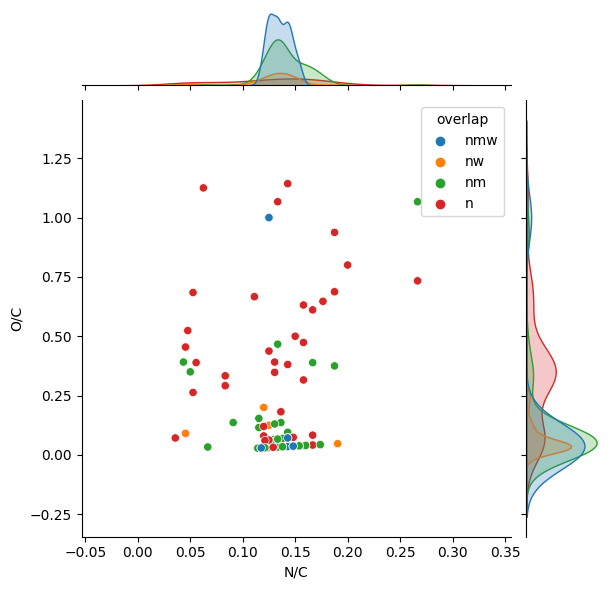

In [350]:
sns.jointplot(data=temp, x='N/C',y='O/C', hue='overlap')

In [270]:
print(np.shape(mzfull_cu_limited_err))
print(np.shape(mz100_cu_limited_err))

combo_cu = pd.concat([mz100_cu_limited_err, mzfull_cu_limited_err])

combo_cu['m/z Window Size'] = combo_cu.Index

for i in range(len(combo_cu['m/z window'])):

    w = combo_cu['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo_cu['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo_cu['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo_cu['m/z Window Size'].iloc[i] = '1000 m/z'

combo_cu['m/z Window Size'].unique()

(105, 53)
(181, 53)


array(['100 m/z', '1000 m/z'], dtype=object)

In [ ]:
mz100_cu_limited_err.columns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


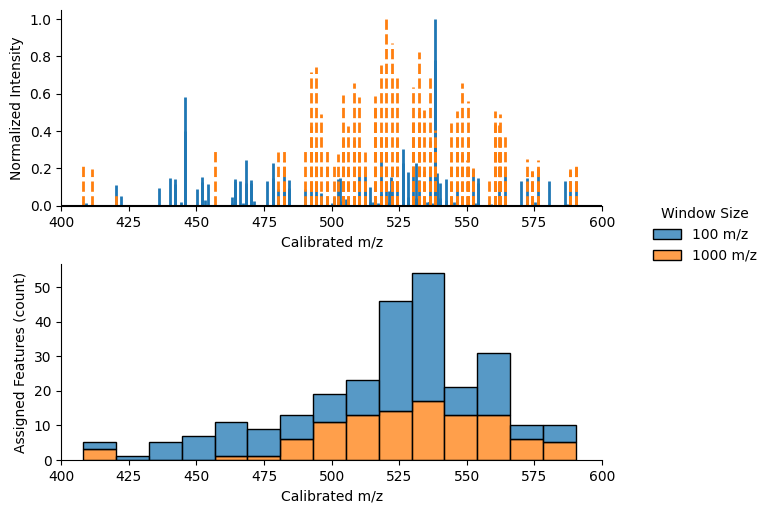

In [35]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .05)

d1=lcmsfns.normMS(mz100_cu_limited_err,mz100_cu_limited_err)
d2=lcmsfns.normMS(mzfull_cu_limited_err,mzfull_cu_limited_err)

ax1_b = plt.subplot(gs1[0])
ax1_b = lcmsfns.plot_ms(df1=d1,  df2=d2, start_mz=400, end_mz=600,ax_ms=ax1_b, norm=True)

sns.despine(ax=ax1_b)

ax1_b.set_ylim(bottom=0)





ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo_cu, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

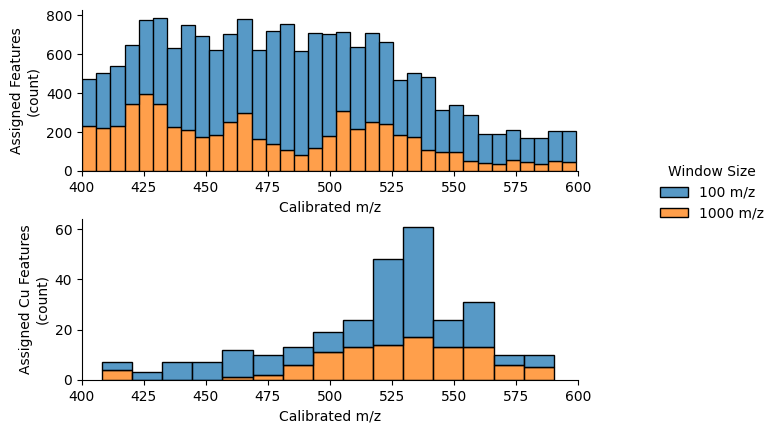

In [275]:
combo = pd.concat([mz100_bs, mzfull_bs])

combo['m/z Window Size'] = combo.Index

for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

combo['m/z Window Size'].unique()


import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])


ax1 = plt.subplot(gs1[0])

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax1)
ax1.set_ylabel('Assigned Features\n(count)')
ax1.legend_.remove()
ax1.set_xlim(400,600)
sns.despine(ax=ax1)




ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo_cu, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Cu Features\n(count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [36]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.25]
mz100_EICdic = {}
for mz,file,mf in zip(mz100_cu_limited_err['m/z'],mz100_cu_limited_err['file'],mz100_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']    
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    mz100_EICdic[mf]=EIC[0][mz]
    #mz100_EICdic[mz]={'eic':EIC[0][mz],'formula':mf}


In [37]:
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.25]
fullmz_EICdic = {}
for mz,file,mf in zip(mzfull_cu_limited_err['m/z'],mzfull_cu_limited_err['file'],mzfull_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    fullmz_EICdic[mf]=EIC[0][mz]

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_ENV.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu', '115In']

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec13.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
# C23 H32 O3 Cu

sub = combo[combo['Molecular Formula'] == 'C23 H32 O3 Cu1']

sub

In [ ]:
for i in range(len(mz100_cu_limited_err.index)):

    mf = mz100_cu_limited_err['Molecular Formula'].iloc[i]
    
    if mf in mzfull_cu_limited_err['Molecular Formula'].values:

        print('\n\nNarrow m/z:')
        print(mz100_cu_limited_err.iloc[i,:])

        ind = mzfull_cu_limited_err[mzfull_cu_limited_err['Molecular Formula'] == mf].index 
        print('\nFull m/z:')
        print(mzfull_cu_limited_err.loc[ind].squeeze())




In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec5.pdf')


for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
refs = pd.read_csv('/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref')
#r45 = refs[(refs['m/z value']>=400) & (refs['m/z value']<=500)]

print(refs[' m/z value'])


'C13 H19 O3 N1'

In [165]:
import math
#assigned_100mz
#assigned_200mz
#assigned_fullmz[assigned_fullmz['13C'] == 1]
test1 = []
test2 = []
for i in range(len(unique_fullmz[unique_fullmz['13C'] == 1].index)):
    
    r13c = unique_fullmz[unique_fullmz['13C'] == 1].iloc[i]
    mf13c = r13c['Molecular Formula']
    iso_sim = r13c['Isotopologue Similarity']
    
    mono_index = int(r13c['Mono Isotopic Index'])

    r13c.fillna(0,inplace=True)
    nC = int(r13c['C'])
    n13C = int(r13c['13C'])
    nH = int(r13c['H'])
    nO = int(r13c['O'])
    nN = int(r13c['N'])

    if (nO > 0) and (~math.isnan(nO)):
        mf_t = 'C%s H%s O%s' %((nC + n13C),nH,nO)
    elif (nN > 0) and (~math.isnan(nN)):
        mf_t = 'C%s H%s O%s N%s' %((nC + n13C),nH,nO, nN)
    else:
        mf_t = 'C%s H%s' %((nC + n13C),nH)

   # print('\n',mf_t)
    if mf_t in unique_fullmz['Molecular Formula']:
        print('yyy')
        print(unique_fullmz[unique_fullmz['Molecular Formula'] == mf_t])
    #mf12c = unique_fullmz[unique_fullmz['Isotopologue Similarity']==iso_sim]['Molecular Formula']

    #temp2 = mf12c.values
    #print('\ntemp2')
    #print(temp2)
    #for i in range(len(temp2)):
    #    test2.append(temp2[i])

    mf12c_in = unique_fullmz[unique_fullmz['Index']==mono_index]
    best_match = mf12c_in[mf12c_in['Isotopologue Similarity']==iso_sim]['Molecular Formula']

    temp=best_match.values
    print('temp')
    print(mf13c,mono_index,temp)
    for i in range(len(temp)):
        test1.append(temp[i])


#print('\n', mf13c,'\n',best_match)

print(len(test1))

temp
C15 H20 O11 N4 13C1 229 ['C16 H20 O11 N4']
temp
C23 H38 O4 13C1 248 []
temp
C13 H22 O1 13C1 32 ['C14 H22 O1']
temp
C11 H16 O3 13C1 36 ['C12 H16 O3']
temp
C12 H20 O2 13C1 37 ['C13 H20 O2']
temp
C12 H22 O2 13C1 46 ['C13 H22 O2']
temp
C12 H24 O2 13C1 51 ['C13 H24 O2']
temp
C11 H22 O3 13C1 65 ['C12 H22 O3']
temp
C14 H20 O1 13C1 74 ['C15 H20 O1']
temp
C9 H16 O5 13C1 72 ['C10 H16 O5']
temp
C13 H20 O2 13C1 92 ['C14 H20 O2']
temp
C14 H22 O1 13C1 84 ['C15 H22 O1']
temp
C11 H14 O4 13C1 97 ['C12 H14 O4']
temp
C13 H22 O2 13C1 100 ['C14 H22 O2']
temp
C13 H24 O2 13C1 114 ['C14 H24 O2']
temp
C11 H20 O4 13C1 133 ['C12 H20 O4']
temp
C11 H18 O4 13C1 120 ['C12 H18 O4']
temp
C13 H26 O2 13C1 122 ['C14 H26 O2']
temp
C14 H12 O2 13C1 109 ['C15 H12 O2']
temp
C12 H22 O3 13C1 121 ['C13 H22 O3']
temp
C14 H24 O2 13C1 169 ['C15 H24 O2']
temp
C19 H37 O4 N1 13C1 153 ['C20 H37 O4 N1']
temp
C14 H22 O2 13C1 159 ['C15 H22 O2']
temp
C9 H20 O4 N2 13C1 151 ['C10 H20 O4 N2']
temp
C21 H34 O4 13C1 162 ['C22 H34 O4']
temp


In [176]:
mono_indices = []
iso_indices = []
for i in unique_fullmz[unique_fullmz['13C'] == 1].index:

    r13c = unique_fullmz.loc[i]

    mf13c = r13c['Molecular Formula']
    iso_sim = r13c['Isotopologue Similarity']    
    mono_index = int(r13c['Mono Isotopic Index'])

    mf12c_in = unique_fullmz[unique_fullmz['Index']==mono_index]
    best_match = mf12c_in[mf12c_in['Isotopologue Similarity']==iso_sim].index

    if len(best_match.values) > 0:
        
        mono_indices.append(best_match.values[0])

        iso_indices.append(i)

print(len(mono_indices),len(iso_indices))

3884 3884


In [338]:
df = assigned_fullmz[assigned_fullmz['file'] == '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw']
df = assigned_100mz_456[assigned_fullmz['file'] == '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw']

intensity_v_ratio = []

for t in df['Time'].unique():

    print(t)

    time_sub = df[df['Time'] == t]

    time_sub['13C'].fillna(0)
   # print(time_sub['Index'])
    if 1.0 in time_sub['13C'].values:

        for i in time_sub[time_sub['13C'] == 1].index:

            iso_row = time_sub.loc[i]

            #print(iso_row)

            mf_13C = iso_row['Molecular Formula']
            mono_index = int(iso_row['Mono Isotopic Index'])
            mf_12C = time_sub[time_sub['Index']==mono_index]['Molecular Formula']
            nC =  time_sub[time_sub['Index']==mono_index]['C'].iloc[0]
            #print(mf_13C, mono_index, mf_12C)

            int_13C = iso_row['Peak Height']
            mz_13C = iso_row['Calibrated m/z']
            int_12C =  time_sub[time_sub['Index']==mono_index]['Peak Height'].iloc[0]
            mz_12C =  time_sub[time_sub['Index']==mono_index]['Calibrated m/z'].iloc[0]
            print(int_12C, int_13C, nC, mz_12C, mz_13C)
            intensity_v_ratio.append([int_12C, int_13C, nC, mz_12C, mz_13C])







2
64763.41110661931 11748.468304746622 24.0 391.284235875306 392.28758155668777
4
31541.166691861366 3727.583333590868 15.0 302.1961944577592 303.199559256239
51064.64707850724 5846.3245841654725 18.0 384.1652991637872 385.1686516660119
83531.60441857536 20170.751934595333 24.0 391.2842869410901 392.2876403530941
59140.7812254013 8359.188999698295 19.0 396.165295298004 397.1686493345333
81260.55089978442 11443.295247922357 19.0 398.1809443629496 399.18429311734286
54670.04738660231 6540.280609188256 19.0 400.19659676867263 401.1999506043157
65697.62227510777 9973.840033563873 20.0 410.1809474176512 411.1843055550702
57358.99363382836 8480.321401074512 19.0 412.16021222339856 413.163582266183
76457.37861530737 12265.64893092424 20.0 412.1965991231178 413.19995274794354
73152.5982640613 10408.890574542227 19.0 414.1758607536048 415.1792121501287
34207.54146208571 6910.769079524172 22.0 421.1856893999728 422.1890235269504
54958.471533577016 7810.097765756221 21.0 424.1965981538872 425.199

In [339]:
df = np.asarray(intensity_v_ratio)
np.shape(df)
df1 = df #[df[:,0]<1e5]

pddf = pd.DataFrame(df1,columns=['12C Intensity','13C Intensity','nC', 'm/z 12C', 'm/z 13C'])


In [217]:
import scipy

df1 = df[df[:,0]<1e5]
logx = np.log10(df1[:,0])
logy = np.log10(df1[:,2])

logyerr = np.std(df1[:,1]) / df1[:,2]

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = scipy.optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

[ 1.66964859 -0.05960914]
[[1953.50811998 -433.66296594]
 [-433.66296594   96.92639562]]


1133.7432972665931
Parameters [ 2.67747781e-01 -9.45250273e+02  1.00000000e+00  1.00000000e+00]
RMSE: 0.10363671443971555
R-squared: 0.055740658543972144


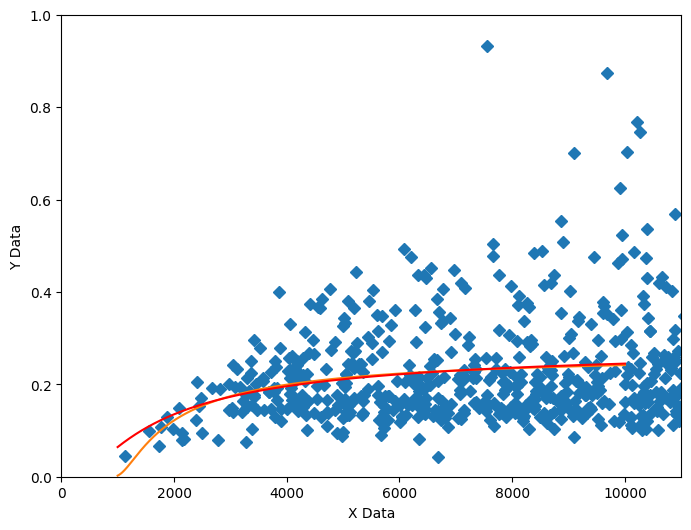

In [196]:
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

nn = 1e4
df1 = df[df[:,0]<nn]

xData = df1[:,0]
yData = df1[:,1]

xmin = min(xData)
print(xmin)
def func(x, a,  b, c, d): # Sigmoid A With Offset from zunzun.com
    #return a*(x-d)**3 + b*(x-d)**2 + c*x 
    return a*np.exp(b/((x-800)))
    return a*(x-d)**5 + b*(x-d)**2 + c*(x-d)

def func2(x, a,  b, c, d): # Sigmoid A With Offset from zunzun.com
    #return a*(x-d)**3 + b*(x-d)**2 + c*x 
    return a*np.exp((b-x)/((x)))
    return a*(x-d)**5 + b*(x-d)**2 + c*(x-d)

# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)



# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData)
fittedParameters2, pcov2 = curve_fit(func2, xData, yData)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(df[:,0], df[:,1],  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(1000, nn, int(1e6))
    yModel = func(xModel, *fittedParameters)

    xModel2 = np.linspace(1000, nn, int(1e6))
    yModel2 = func2(xModel2, *fittedParameters2)
    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.plot(xModel2, yModel2, color ='red')

    axes.set_xlim(0,1.1*nn)
    axes.set_ylim(0,1)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

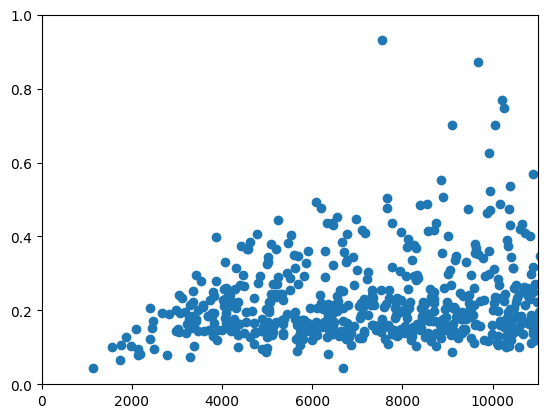

In [340]:


fig, ax = plt.subplots()

ax.scatter(pddf['12C Intensity'], pddf['12C Intensity']/pddf['13C Intensity']/pddf['nC'])

#ax.errorbar(df1[:,0], df1[:,1], yerr=np.std(df1[:,1]), fmt='k.')  # Data

ax.set_ylim(0,1)

ax.set_xlim(0,1.1e4)
plt.show()

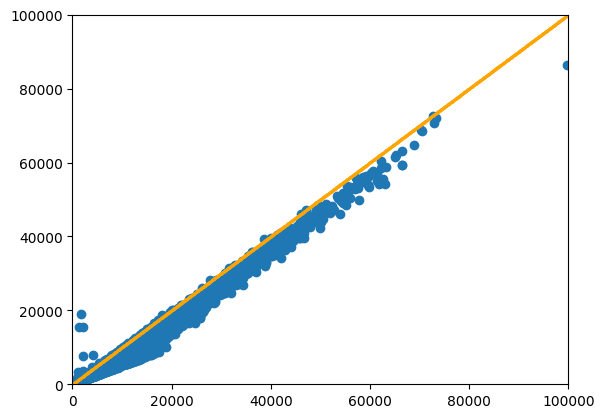

In [341]:


xx = np.linspace(1, int(5e5), int(1e4))
yy = np.linspace(1, int(5e5), int(1e4))


fig, ax = plt.subplots()

#ax.scatter((pddf['nC']*1.1/100*pddf['12C Intensity']),(pddf['13C Intensity']-(pddf['nC']*1.1/100*pddf['12C Intensity']))/(pddf['nC']*1.1/100*pddf['12C Intensity']))
ax.scatter((pddf['nC']*1.1/100*pddf['12C Intensity']),pddf['13C Intensity'])
#ax.scatter((pddf['nC']*pddf['12C Intensity']),pddf['13C Intensity'])

ax.scatter(xx, yy, color='orange',s=1)

ax.set_xlim(0,10e4)
ax.set_ylim(0,10e4)
ax.plot

plt.show()

findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif'

[ 1.         30.61410169  1.        ]


findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.
findfont: Font family 'nonserif' not found.


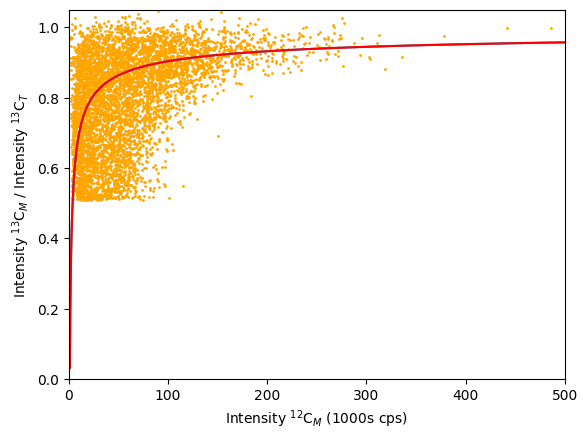

In [497]:
def func2(x, a,  b, c): # Sigmoid A With Offset from zunzun.com
    return 1 - b/((x)**0.5)


yy = (pddf['nC']*1.07/100*pddf['12C Intensity'])
xx = pddf['12C Intensity']

fittedParameters2, pcov2 = curve_fit(func2, xx,  pddf['13C Intensity']/yy)

print(fittedParameters2)
fig, ax = plt.subplots()

ax.scatter(pddf['12C Intensity'], pddf['13C Intensity']/yy, s=1)


xModel2 = np.linspace(1000, 1e6, int(1e6))
yModel2 = func2(xModel2, *fittedParameters2)
# now the model as a line plot 
ax.plot(xModel2, yModel2)

ax.plot(xModel2, yModel2, color ='red')

ax.set_xlim(0,0.5e6)
ax.set_ylim(0,1.05)

xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

ax.set_xlabel(r'Intensity $^{12}$C$_{M}$' + ' (1000s cps)') #'Monoisotopic intensity (1000s cps)')
ax.set_ylabel(r'Intensity $^{13}$C$_{M}$ / Intensity $^{13}$C$_{T}$')
#ax.set_ylabel(r'$\frac{{{%s}}}{%s}$' %(nom,den))

plt.show()

In [373]:
df_cu = mz100_contains_cu
df_cu['13C'] = df_cu['13C'].fillna(0)
df_cu_mono = df_cu[df_cu['13C']==0]

print(np.shape(df_cu))
print(np.shape(df_cu_mono))

df_cu_mono['Theoretical 65Cu Peak Height'] = df_cu_mono['Peak Height']*.3083

#69.17 and 30.83% 63Cu 65Cu

for i, j in zip(df_cu_mono['Peak Height'], df_cu_mono['Theoretical 65Cu Peak Height']):
    iso_ph = df_cu_mono['C'].iloc[0]*1.1/100*i
    print(i,j, iso_ph)



(181, 54)
(164, 54)
11457.396366481758 3532.3152997863262 3276.815360813783
267.2356482172144 82.38875034536721 76.42939539012333
197.7737919423189 60.97366005581692 56.56330449550321
303.4946860961483 93.56741172344253 86.79948022349842
149.3044444610934 46.030560227355096 42.701071115872715
312.7423878327792 96.41847816884582 89.44432292017486
395.6885779918736 121.99078859489464 113.16693330567587
241.9589447484151 74.59594266593638 69.20025819804673
454.0665804394631 139.9887267494865 129.86304200568645
148.7851891134067 45.87047380366329 42.552564086434316
280.1243942728269 86.36235075431254 80.11557676202851
211.85880424765588 65.31606934955231 60.59161801482959
389.0255112657844 119.93656512324134 111.26129622201435
399.2176294390797 123.07879515606828 114.1762420195768
115.6331137250231 35.64968896142462 33.07107052535661
294.5319876812148 90.80421180211853 84.23614847682744
426.188038390537 131.39377223580254 121.88977897969359
431.1118916348048 132.91179619101032 123.29800100